In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

data_folder = "/Users/jiang/data/rain_kakuho"
grib_files = glob.glob(os.path.join(data_folder,"*.000"))  # 288 = 12*24
grib_files.sort()

/Users/jiang/github_all/rainymotion/docs/notebooks


In [3]:
grib_files

[]

### convert wgrib2 file into nc file

In [6]:
varlist = [":{} min".format(i) for i in range(5,185,5)]  # create a varaible list from 5 to 180 min
var = '|'.join(varlist)
for grib_file in grib_files:
    cmd = "wgrib2 {0} -s | egrep '({1})'|wgrib2 -i {0} -netcdf {2}".format(grib_file, var, grib_file +".nc")
    fail = os.system(cmd)  # 0 indicate success, others indicate fail
    if fail:
        print("wgrib2 wrong at ", grib_file)

In [22]:
from netCDF4 import Dataset
nc_file = grib_files[0] +".nc"
root = Dataset(nc_file, "r")

from datetime import datetime,timedelta
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d %H:%M UTC ')
print(date_string)

2020-01-08 08:25 UTC 


In [24]:
root['APCP_surface'].shape  # shape (36, 3360, 2560)
rain = root['APCP_surface'][0,:,:]
rain_reduced = rain[1500:2500,1000:2000].copy()
rain_reduced.fill_value = 0.0
rain_filled = rain_reduced.filled().astype('float16')

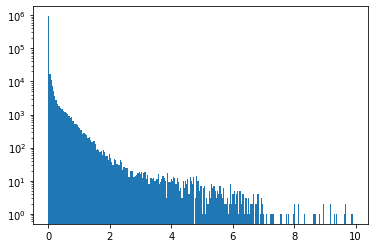

In [21]:
plt.hist(rain_filled.ravel(),256)
plt.yscale('log')

## visualize kakuho image data

In [15]:
from datetime import datetime,timedelta
import joblib
from netCDF4 import Dataset
from rainymotion import models, metrics, utils

kakuho_folder = "/Users/jiang/data/rain_kakuho"
radar_folder = "/Users/jiang/data/jma_radar"

time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt_now = datetime(2020,1,23,0,0)
dt_pre = dt_now - timedelta(seconds = time_step)
dt_12  = dt_now + timedelta(seconds = time_step * 12)
yday_pre = dt_pre.strftime('%Y_%m_%d')
yday_now = dt_now.strftime('%Y_%m_%d')
yday_12  = dt_12.strftime('%Y_%m_%d')
    
hh = str(dt_now.hour).zfill(2) 
mm = str(dt_now.minute).zfill(2)

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
if yday_str not in daily_database:
    daily_database[yday_str] = joblib.load(os.path.join(radar_folder, 
                                                        f"jma_radar_uint8_{yday_str}.joblib")) 
if yday_12 not in daily_database:
    daily_database[yday_12]  = joblib.load(os.path.join(radar_folder,
                                                        f"jma_radar_uint8_{yday_12}.joblib")) 

sequence_in_day = int(dt.hour*12 + (dt.minute)/5)    
#inputs[0,:,:] = daily_database[yday_str][sequence_in_day]/10.0
#inputs[1,:,:] = daily_database[yday_now][(sequence_in_day+1)%288]/10.0
    
#model = models.Dense()    
#model.input_data = inputs
#model.lead_steps = 13
#nowcast = model.run()  # shape (13, 1000, 1000)
#dense_13_th = []  # threat score

# load kakuho data from wgrib2 file
grib_file = dt_now.strftime('%Y%m%d_%H%M00.000')
source_folder = os.path.join(kakuho_folder, dt_now.strftime("%Y/%m/%d"))
source_path = os.path.join(source_folder, grib_file)
nc_file = source_path + ".nc"
varlist = [":{} min".format(i) for i in range(5,65,5)]
var = '|'.join(varlist)
cmd = "wgrib2 {0} -s | egrep '({1})'|wgrib2 -i {0} -netcdf {2}".format(source_path, var, nc_file)
fail = os.system(cmd)  # 0 indicate success, others indicate fail
if fail:
    print("wgrib2 wrong at ", grib_file)

root = Dataset(nc_file, "r")        
# delete nc                     
os.system(f"rm -r {nc_file}") 

for i in range (1,13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    
    rain_reduced = root['APCP_surface'][i-1,1500:2500,1000:2000]
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled().astype('float16') * 6 # mm/10 min to mm/h
            
    hits, misses, falsealarms, _ = metrics.prep_clf(ground_truth,rain_filled, threshold = threshold)

    threat =  hits / (hits + misses + falsealarms)
    recall =  hits / (hits + misses)
    precision = hits / (hits + falsealarms)
    
    plt.figure(dpi = 100)
    
    image1 = ground_truth
    image2 = rain_filled
    plt.imshow(np.log(image1 + 0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2 + 0.01).astype('float32'),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {yday_now}-{hh}:{mm} UTC,+{str(i*5).zfill(2)}min")
    plt.text(20, 950, f"rainy pixels = {np.sum(image1 >= threshold)/(1e6 - 132396) *100 :.1f} %")
    plt.text(20, 900, f"threshold = {threshold} mm/h")
    plt.text(20, 850, f"threat = {threat:.2f}")
    plt.text(20, 800, f"recall = {recall:.2f}")
    plt.text(20, 750, f"precision = {precision:.2f}")
    plt.text(20, 700, "Truth(Reds)",color = "red")
    plt.text(20, 650, "Kakuho(Blues)",color = "blue")
    plt.grid()
    plt.tight_layout(h_pad=0.5)
    plt.savefig("JMA_kakuho_image_score" + str(i).zfill(2) + ".png",format = "png",bbox_inches='tight')
    plt.close()

In [16]:
import imageio
png_files = glob.glob("./JMA_kakuho_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = f'JMA_kakuho_image_score-{yday_now}.gif'
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

12


In [30]:
for i in range(12):
    rain_reduced = root['APCP_surface'][i,1500:2500,1000:2000]
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled().astype('float16') * 6 # mm/10 min to mm/h
    print(np.unique(rain_filled.flatten()))

[ 0.      0.2998  0.306  ... 30.61   30.81   31.53  ]
[ 0.      0.2998  0.306  ... 30.42   30.52   30.61  ]
[ 0.      0.2998  0.306  ... 29.47   29.84   29.97  ]
[ 0.      0.2998  0.306  ... 29.19   29.53   29.67  ]
[ 0.      0.2998  0.306  ... 26.2    26.34   27.72  ]
[ 0.      0.2998  0.306  ... 26.47   27.33   28.73  ]
[ 0.      0.2998  0.306  ... 26.4    26.44   27.42  ]
[ 0.      0.2998  0.306  ... 25.25   25.36   25.38  ]
[ 0.      0.2998  0.306  ... 24.03   24.28   24.6   ]
[ 0.      0.2998  0.306  ... 23.31   23.64   24.    ]
[ 0.      0.2998  0.306  ... 22.94   23.36   23.78  ]
[ 0.      0.2998  0.306  ... 22.6    22.64   22.69  ]


In [32]:
np.unique(rain_filled.flatten())[0:20]

array([0.    , 0.2998, 0.306 , 0.312 , 0.318 , 0.324 , 0.33  , 0.336 ,
       0.342 , 0.3481, 0.354 , 0.3599, 0.366 , 0.372 , 0.378 , 0.3843,
       0.3901, 0.396 , 0.402 , 0.408 ], dtype=float16)

In [31]:
print(np.unique(ground_truth.flatten()))

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.1  2.3  2.6  2.8  2.9  3.1  3.3  3.6
  3.8  4.1  4.3  4.6  4.8  4.9  5.2  5.7  5.9  6.2  6.7  6.9  7.2  7.7
  7.9  8.2  8.7  8.9  9.2  9.7  9.9 10.5 11.5 11.9 12.5 13.5 14.5 15.5
 15.9 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5]


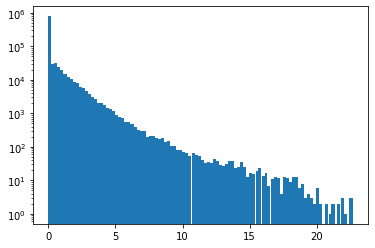

In [28]:
plt.hist(rain_filled.flatten(),100)
plt.yscale('log')
plt.show()

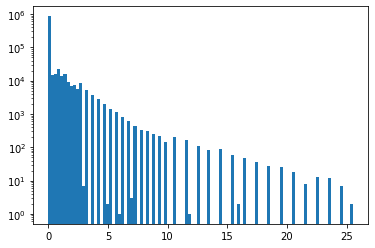

In [27]:
plt.hist(ground_truth.flatten(),100)
plt.yscale('log')
plt.show()